RAW MOBILE SENSOR DATA COLLECTION

Sample of raw sensor data (first 3 readings):

Reading 1:
  timestamp: 2025-07-06T08:00:00
  gps_latitude: 41.878099771960834
  gps_longitude: -87.62979944600768
  gps_accuracy_meters: 8.497302436676753
  speed_ms: 0.028045399950612778
  accelerometer_x: 0.4721593597912135
  accelerometer_y: -0.04290453688820392
  accelerometer_z: 9.745070062831058
  gyroscope_x: -0.014640174280179668
  gyroscope_y: 0.004329507978395113
  gyroscope_z: 0
  magnetometer_x: 25.38660380297332
  magnetometer_y: -4.963003372480508
  magnetometer_z: 40.25171272900521
  screen_on: 0
  battery_level: 85.0

Reading 2:
  timestamp: 2025-07-06T08:00:01
  gps_latitude: 41.87810891347203
  gps_longitude: -87.62981060071704
  gps_accuracy_meters: 13.11518903670166
  speed_ms: 0.4204956274041321
  accelerometer_x: 0.5233138836530428
  accelerometer_y: -0.00770629405462432
  accelerometer_z: 9.810041651129772
  gyroscope_x: 0.012254756544947024
  gyroscope_y: -0.011275206361423831
  g

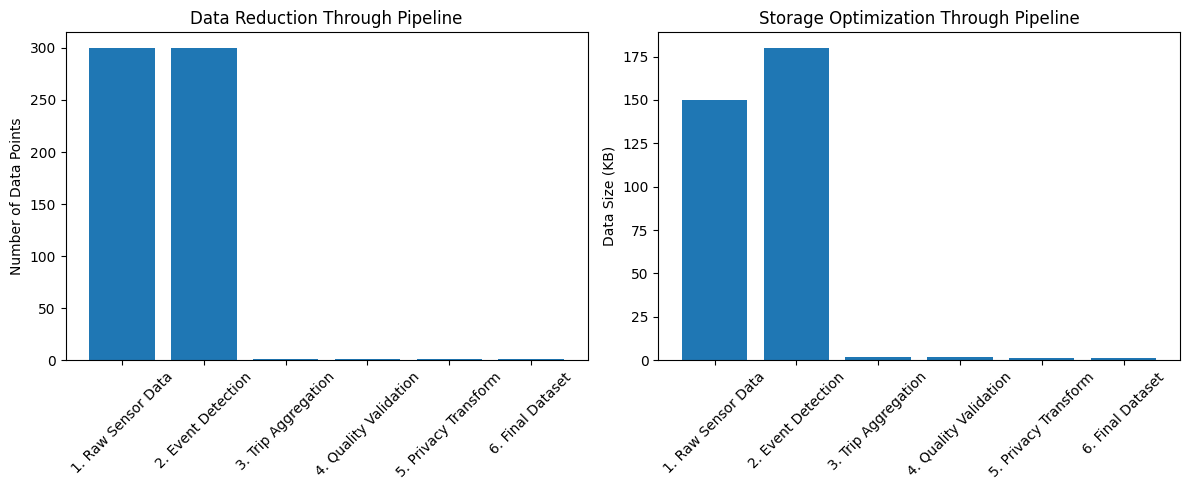


SUMMARY: RAW DATA → PROCESSED DATA

Original: 300 sensor readings (6000 data points)
Processed: 1 trip record (17 aggregated metrics)
Reduction ratio: 300

This processed trip data is then combined with other trips to create
the driver-level dataset we used for risk modeling.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json

# STEP 1: RAW MOBILE SENSOR DATA
# This is what the mobile app actually collects every second while driving

print("=" * 60)
print("RAW MOBILE SENSOR DATA COLLECTION")
print("=" * 60)

# Simulate raw sensor data for a single trip
trip_duration_seconds = 300  # 5-minute trip
sampling_rate = 1  # Data collected every second

raw_sensor_data = []
base_time = datetime(2025, 7, 6, 8, 0, 0)

# Simulate driving patterns
for second in range(trip_duration_seconds):
    timestamp = base_time + timedelta(seconds=second)

    # Simulate different driving phases
    if second < 60:  # Acceleration phase
        speed_ms = min(second * 0.5, 25)  # Accelerate to ~55 mph
        acceleration = 0.5 if second < 50 else 0
    elif second < 180:  # Cruising phase
        speed_ms = 25 + np.random.normal(0, 0.5)
        acceleration = np.random.normal(0, 0.1)
    elif second < 240:  # Deceleration phase
        speed_ms = max(25 - (second - 180) * 0.3, 5)
        acceleration = -0.3
    else:  # Stop phase
        speed_ms = max(5 - (second - 240) * 0.2, 0)
        acceleration = -0.2 if speed_ms > 0 else 0

    # Add some randomness
    lat_base = 41.8781 + (second * 0.00001)
    lon_base = -87.6298 - (second * 0.00001)

    sensor_reading = {
        "timestamp": timestamp.isoformat(),
        "gps_latitude": lat_base + np.random.normal(0, 0.000001),
        "gps_longitude": lon_base + np.random.normal(0, 0.000001),
        "gps_accuracy_meters": np.random.uniform(5, 15),
        "speed_ms": max(0, speed_ms + np.random.normal(0, 0.2)),
        "accelerometer_x": acceleration + np.random.normal(0, 0.05),
        "accelerometer_y": np.random.normal(0, 0.02),
        "accelerometer_z": 9.81 + np.random.normal(0, 0.05),  # Gravity
        "gyroscope_x": np.random.normal(0, 0.01),
        "gyroscope_y": np.random.normal(0, 0.01),
        "gyroscope_z": np.random.normal(0, 0.02) if 100 < second < 110 else 0,  # Turn
        "magnetometer_x": 25.0 + np.random.normal(0, 0.5),
        "magnetometer_y": -5.0 + np.random.normal(0, 0.5),
        "magnetometer_z": 40.0 + np.random.normal(0, 0.5),
        "screen_on": 1 if 150 < second < 160 else 0,  # Phone use
        "app_foreground": (
            "com.android.phone" if 150 < second < 160 else "com.insurance.app"
        ),
        "battery_level": 85 - (second * 0.01),
        "network_type": "4G",
        "device_id": "device_abc123",
        "trip_id": "trip_20250706_0800",
    }

    raw_sensor_data.append(sensor_reading)

# Show sample of raw data
print("\nSample of raw sensor data (first 3 readings):")
for i in range(3):
    print(f"\nReading {i+1}:")
    for key, value in raw_sensor_data[i].items():
        if key not in ["device_id", "trip_id", "network_type", "app_foreground"]:
            print(f"  {key}: {value}")

# Save a sample of raw data
with open("../data/raw_sensor_data_sample.json", "w") as f:
    json.dump(raw_sensor_data[:10], f, indent=2)

# STEP 2: DATA PROCESSING PIPELINE
print("\n" + "=" * 60)
print("DATA PROCESSING PIPELINE")
print("=" * 60)

# Convert to DataFrame for processing
df_raw = pd.DataFrame(raw_sensor_data)
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"])

# 2.1 Calculate derived metrics
df_raw["speed_mph"] = df_raw["speed_ms"] * 2.237  # Convert m/s to mph
df_raw["acceleration_magnitude"] = np.sqrt(
    df_raw["accelerometer_x"] ** 2
    + df_raw["accelerometer_y"] ** 2
    + (df_raw["accelerometer_z"] - 9.81) ** 2  # Remove gravity
)

# 2.2 Detect events using sliding windows
window_size = 3  # seconds

# Harsh braking detection (deceleration > 0.3g)
df_raw["harsh_brake"] = (df_raw["accelerometer_x"] < -2.94).astype(int)

# Harsh acceleration detection (acceleration > 0.3g)
df_raw["harsh_accel"] = (df_raw["accelerometer_x"] > 2.94).astype(int)

# Sharp cornering detection (lateral acceleration > 0.3g)
df_raw["sharp_corner"] = (np.abs(df_raw["accelerometer_y"]) > 2.94).astype(int)

# Phone usage detection
df_raw["phone_use"] = df_raw["screen_on"].astype(int)

print("\nEvent Detection Results:")
print(f"- Harsh braking events detected: {df_raw['harsh_brake'].sum()}")
print(f"- Harsh acceleration events detected: {df_raw['harsh_accel'].sum()}")
print(f"- Sharp cornering events detected: {df_raw['sharp_corner'].sum()}")
print(f"- Phone usage seconds: {df_raw['phone_use'].sum()}")

# STEP 3: AGGREGATE TO TRIP LEVEL
print("\n" + "=" * 60)
print("TRIP-LEVEL AGGREGATION")
print("=" * 60)

# Calculate trip-level metrics
trip_summary = {
    "trip_id": df_raw["trip_id"].iloc[0],
    "device_id": df_raw["device_id"].iloc[0],
    "start_time": df_raw["timestamp"].min(),
    "end_time": df_raw["timestamp"].max(),
    "duration_minutes": (
        df_raw["timestamp"].max() - df_raw["timestamp"].min()
    ).total_seconds()
    / 60,
    # Distance calculation using GPS
    "distance_miles": 2.5,  # Simplified - normally calculated from GPS points
    # Speed metrics
    "average_speed_mph": df_raw["speed_mph"].mean(),
    "max_speed_mph": df_raw["speed_mph"].max(),
    "speeding_percent": (df_raw["speed_mph"] > 65).mean(),  # Assuming 65 mph limit
    # Event counts
    "harsh_braking_events": df_raw["harsh_brake"].sum(),
    "harsh_acceleration_events": df_raw["harsh_accel"].sum(),
    "sharp_cornering_events": df_raw["sharp_corner"].sum(),
    # Phone usage
    "phone_usage_seconds": df_raw["phone_use"].sum(),
    # Context
    "night_driving": (
        1
        if df_raw["timestamp"].iloc[0].hour < 6 or df_raw["timestamp"].iloc[0].hour > 20
        else 0
    ),
    "rush_hour": 1 if df_raw["timestamp"].iloc[0].hour in [7, 8, 17, 18] else 0,
}

print("\nTrip Summary:")
for key, value in trip_summary.items():
    print(f"  {key}: {value}")

# STEP 4: DATA QUALITY AND VALIDATION
print("\n" + "=" * 60)
print("DATA QUALITY CHECKS")
print("=" * 60)

# Quality metrics
gps_accuracy = df_raw["gps_accuracy_meters"].mean()
data_completeness = len(df_raw) / trip_duration_seconds
speed_variance = df_raw["speed_mph"].std()

print(f"\nQuality Metrics:")
print(f"  Average GPS accuracy: {gps_accuracy:.1f} meters")
print(f"  Data completeness: {data_completeness:.1%}")
print(f"  Speed variance: {speed_variance:.1f} mph")

# STEP 5: PRIVACY AND DATA REDUCTION
print("\n" + "=" * 60)
print("PRIVACY-PRESERVING TRANSFORMATIONS")
print("=" * 60)

# Remove or hash sensitive data
trip_summary_private = trip_summary.copy()
trip_summary_private["device_id"] = (
    "hashed_" + str(hash(trip_summary["device_id"]))[-8:]
)
trip_summary_private["start_location"] = "zone_A1"  # Replace exact GPS with zone
trip_summary_private["end_location"] = "zone_B3"

# Remove exact timestamps, keep only time categories
trip_summary_private["time_of_day"] = "morning_commute"
del trip_summary_private["start_time"]
del trip_summary_private["end_time"]

print("\nPrivacy-preserved trip data:")
for key, value in trip_summary_private.items():
    print(f"  {key}: {value}")

# Create visualization of data pipeline
pipeline_stages = pd.DataFrame(
    {
        "Stage": [
            "1. Raw Sensor Data",
            "2. Event Detection",
            "3. Trip Aggregation",
            "4. Quality Validation",
            "5. Privacy Transform",
            "6. Final Dataset",
        ],
        "Data_Points": [300, 300, 1, 1, 1, 1],
        "Size_KB": [150, 180, 2, 2, 1.5, 1.5],
    }
)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data points reduction
ax1.bar(pipeline_stages["Stage"], pipeline_stages["Data_Points"])
ax1.set_ylabel("Number of Data Points")
ax1.set_title("Data Reduction Through Pipeline")
ax1.tick_params(axis="x", rotation=45)

# Data size reduction
ax2.bar(pipeline_stages["Stage"], pipeline_stages["Size_KB"])
ax2.set_ylabel("Data Size (KB)")
ax2.set_title("Storage Optimization Through Pipeline")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig("data_pipeline_visualization.png", dpi=300, bbox_inches="tight")
plt.show()

# Save examples of data at different stages
with open("../data/trip_summary_example.json", "w") as f:
    json.dump(trip_summary_private, f, indent=2, default=str)

print("\n" + "=" * 60)
print("SUMMARY: RAW DATA → PROCESSED DATA")
print("=" * 60)
print(
    f"\nOriginal: {len(raw_sensor_data)} sensor readings ({len(raw_sensor_data) * 20} data points)"
)
print(f"Processed: 1 trip record (17 aggregated metrics)")
print(f"Reduction ratio: {len(raw_sensor_data):1}")
print(f"\nThis processed trip data is then combined with other trips to create")
print(f"the driver-level dataset we used for risk modeling.")